# This notebook will run the model using only Crash Service and Loose Livestock Category Classes

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.cluster
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

Import data of clean features

In [3]:
file = '/Users/tshields/Documents/GitHub/Real-Time_Traffic_Incident_Reports/FeatureEngineering/feature_engineering4.csv'

In [4]:
df = pd.read_csv(file, index_col=0)
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km
0,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June,cnw,ne,1.849061
1,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10,June,vne,ne,9.009002
2,2020-04-17 21:25:03+00:00,Crash Service,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April,vce,ne,12.228301
3,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21,April,vsw,sw,7.357232
4,2020-04-17 21:00:55+00:00,Crash Service,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April,vse,se,10.665180


In [5]:
df.describe()

,Latitude,Longitude,issue_timespan,hour,dist_cntr_km
count,243114.000000,243114.000000,243114.000000,243114.000000,243114.000000
mean,30.301716,-97.733273,72.641459,13.659287,11.826093
std,0.093666,0.086736,90.826579,7.055001,7.320069
min,30.004413,-98.226709,0.333333,0.000000,0.007638
25%,30.232036,-97.776903,20.766667,9.000000,6.040102
50%,30.294241,-97.734390,41.316667,15.000000,10.961410
75%,30.373598,-97.687501,81.166667,19.000000,16.959760
max,30.798642,-97.293320,480.000000,23.000000,60.669983


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243114 entries, 0 to 243113
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   published_date  243114 non-null  object 
 1   issue_reported  243114 non-null  object 
 2   Latitude        243114 non-null  float64
 3   Longitude       243114 non-null  float64
 4   issue_timespan  243114 non-null  float64
 5   geometry        243114 non-null  object 
 6   day             243114 non-null  object 
 7   hour            243114 non-null  int64  
 8   month           243114 non-null  object 
 9   region          243114 non-null  object 
 10  quadrant        243114 non-null  object 
 11  dist_cntr_km    243114 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 24.1+ MB


In [7]:
df['issue_reported'].unique()

array(['Crash Service', 'Traffic Hazard', 'Collision', 'Stalled Vehicle',
       'Loose Livestock', 'Traffic Impediment'], dtype=object)

In [8]:
df.issue_reported.value_counts()

Crash Service         93808
Traffic Hazard        93012
Collision             32536
Stalled Vehicle       11965
Loose Livestock        5914
Traffic Impediment     5879
Name: issue_reported, dtype: int64

In [9]:
df = df[df["issue_reported"].str.contains("Traffic Hazard|Collision|Stalled Vehicle|Injury/Fatality|Traffic Impediment|Vehicle Fire")==False]

In [10]:
df.issue_reported.value_counts()

Crash Service      93808
Loose Livestock     5914
Name: issue_reported, dtype: int64

#  Use Label Encoder for categorical data we are trying to predict
Trying to predict the "issue_reported" involves transforming the column using LabelEncoder(). Then a quick check to ensure the numbers line up like before.

In [11]:
le = LabelEncoder()
df['issue_reported']=le.fit_transform(df['issue_reported'])
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km
0,2018-06-13 06:35:59+00:00,0,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June,cnw,ne,1.849061
2,2020-04-17 21:25:03+00:00,0,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April,vce,ne,12.228301
4,2020-04-17 21:00:55+00:00,0,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April,vse,se,10.665180
5,2020-04-17 21:44:39+00:00,0,30.353742,-97.690482,140.816667,POINT (-97.690482 30.353742),Friday,21,April,vne,ne,10.868116
12,2020-04-19 00:17:14+00:00,0,30.391843,-97.831017,32.833333,POINT (-97.831017 30.391843),Sunday,0,April,vnw,nw,16.226193


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99722 entries, 0 to 243113
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   published_date  99722 non-null  object 
 1   issue_reported  99722 non-null  int64  
 2   Latitude        99722 non-null  float64
 3   Longitude       99722 non-null  float64
 4   issue_timespan  99722 non-null  float64
 5   geometry        99722 non-null  object 
 6   day             99722 non-null  object 
 7   hour            99722 non-null  int64  
 8   month           99722 non-null  object 
 9   region          99722 non-null  object 
 10  quadrant        99722 non-null  object 
 11  dist_cntr_km    99722 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 9.9+ MB


In [13]:
df['issue_reported'].unique()

array([0, 1])

In [14]:
df['issue_reported'].value_counts()

0    93808
1     5914
Name: issue_reported, dtype: int64

## Apply LabelEncoder on the new categorical column 'region'.

In [15]:
le2 = LabelEncoder()
df['region']=le2.fit_transform(df['region'])
le3 = LabelEncoder()
df['day']=le3.fit_transform(df['day'])
le4 = LabelEncoder()
df['month']=le4.fit_transform(df['month'])
le5 = LabelEncoder()
df['quadrant']=le5.fit_transform(df['quadrant'])
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km
0,2018-06-13 06:35:59+00:00,0,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),6,6,6,2,0,1.849061
2,2020-04-17 21:25:03+00:00,0,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),0,21,0,6,0,12.228301
4,2020-04-17 21:00:55+00:00,0,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),0,21,0,10,2,10.665180
5,2020-04-17 21:44:39+00:00,0,30.353742,-97.690482,140.816667,POINT (-97.690482 30.353742),0,21,0,8,0,10.868116
12,2020-04-19 00:17:14+00:00,0,30.391843,-97.831017,32.833333,POINT (-97.831017 30.391843),3,0,0,9,1,16.226193


## Scaling Timespan and Latitude/Longitude Features
First, create a series variable using .values

In [16]:
series1 = df.issue_timespan.values
series2 = df.dist_cntr_km.values

Then reshape the series to scale it as 2D arrays

In [17]:
series1 = series1.reshape(-1,1)

In [18]:
series2 = series2.reshape(-1,1)

In [19]:
scaler = StandardScaler()

Then create new columns for for each of the series.

In [20]:
df['scaled_timespan'] = scaler.fit_transform(series1)

In [21]:
df['scaled_dist_km'] = scaler.fit_transform(series2)

In [22]:

df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km,scaled_timespan,scaled_dist_km
0,2018-06-13 06:35:59+00:00,0,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),6,6,6,2,0,1.849061,0.559052,-1.285630
2,2020-04-17 21:25:03+00:00,0,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),0,21,0,6,0,12.228301,-0.664957,0.294202
4,2020-04-17 21:00:55+00:00,0,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),0,21,0,10,2,10.665180,0.613600,0.056279
5,2020-04-17 21:44:39+00:00,0,30.353742,-97.690482,140.816667,POINT (-97.690482 30.353742),0,21,0,8,0,10.868116,0.524178,0.087168
12,2020-04-19 00:17:14+00:00,0,30.391843,-97.831017,32.833333,POINT (-97.831017 30.391843),3,0,0,9,1,16.226193,-0.634554,0.902724


## One Hot Encoding the Categorical Variables

In [23]:
dummies = pd.get_dummies(df, columns=['day','hour','month','region', 'quadrant'])

In [24]:
dummies = dummies.drop(columns=['issue_reported', 'issue_timespan', 'Latitude','Longitude', 'geometry', 'published_date', 'dist_cntr_km'])

In [25]:
dummies.head()

,scaled_timespan,scaled_dist_km,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,...,region_6,region_7,region_8,region_9,region_10,region_11,quadrant_0,quadrant_1,quadrant_2,quadrant_3
0,0.559052,-1.285630,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.664957,0.294202,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0.613600,0.056279,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,0.524178,0.087168,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
12,-0.634554,0.902724,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0


In [26]:
X = dummies

In [27]:

y = df.issue_reported

In [28]:
X.shape

(99722, 61)

In [29]:
y.shape

(99722,)

## Train Test Split and Scale

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [32]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
clf = RandomForestClassifier(random_state = 1, max_depth = 25, n_estimators = 500, min_samples_split = 15)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print('Random Forest: Balanced Accuracy=%.3f' % (ba))

Random Forest: Accuracy=0.982
Random Forest: f1-score=0.981
Random Forest: Balanced Accuracy=0.878


## A confusion matrix on Random Forest model

In [34]:
class_names=['Crash Service', 'Loose Livestock'] # name  of classes

Confusion matrix, without normalization
[[28043   106]
 [  425  1343]]
Normalized confusion matrix
[[1.   0.  ]
 [0.24 0.76]]


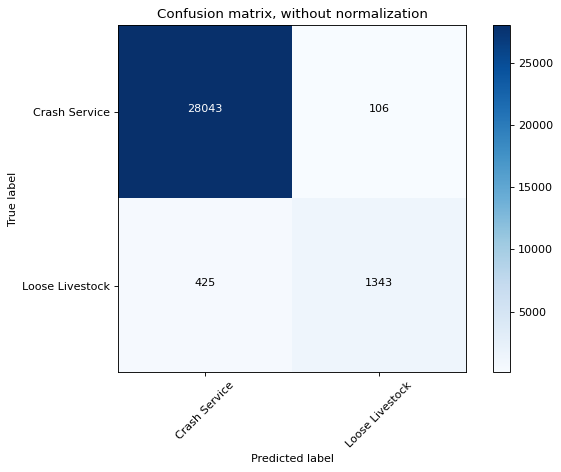

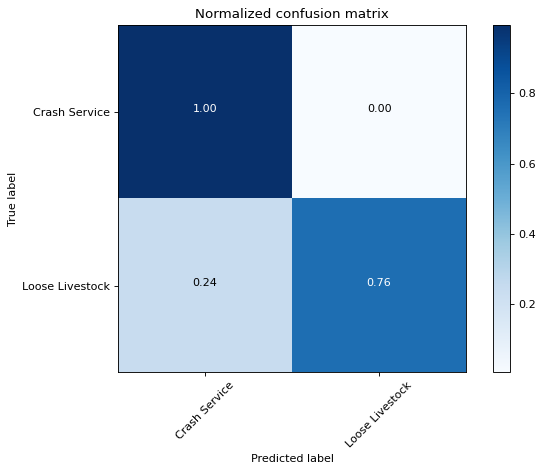

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.988


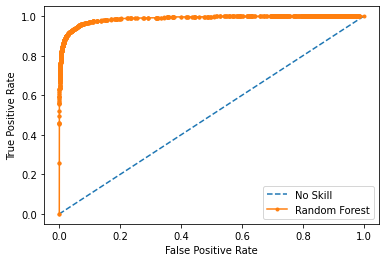

In [42]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
model = RandomForestClassifier(random_state = 1, max_depth = 25, n_estimators = 500, min_samples_split = 15)
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()